There are 2 assumptions about global linear models for normalization: 

    1) most genes are not differentially expressed between cell types
    2) library complexity is independent of cell type 

This problem is related to compositional data analysis. My goal is not to solve compositional data analysis. My goal is to make the counts in scRNAseq as robust as in low input RNAseq. Normalizing and differential expression in low input RNAseq is a different issue altogether. 


In [75]:
library(tidyverse)
library(data.table)
library(magrittr)
library(ggridges)
library(ggthemes)
library(harmony)
library(singlecellmethods)
library(ggrepel)
library(Matrix)
library(patchwork)
library(sctransform)
library(scales)
library(uwot)
library(pheatmap)



In [76]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}


do_scatter <- function(umap_use, meta_data, label_name, no_guides = TRUE, do_labels = TRUE, nice_names, palette_use,
                       pt_size = 4, point_size = .5, base_size = 12, do_points = TRUE, do_density = FALSE, h = 6, w = 8) {
    plt_df <- umap_use %>% data.frame() %>% 
        cbind(meta_data) %>% 
        dplyr::sample_frac(1L) 
    plt_df$given_name <- plt_df[[label_name]]
    
    if (!missing(nice_names)) {
        plt_df %<>%
            dplyr::inner_join(nice_names, by = "given_name") %>% 
            subset(nice_name != "" & !is.na(nice_name))

        plt_df[[label_name]] <- plt_df$nice_name        
    }
        
    plt <- plt_df %>% 
        ggplot(aes_string("X1", "X2", col = label_name, fill = label_name)) + 
#         theme_tufte(base_size = base_size) + 
        theme_test(base_size = base_size) + 
        theme(panel.background = element_rect(fill = NA, color = "black")) + 
        guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 4)), alpha = FALSE) +
        scale_color_manual(values = palette_use) + 
        scale_fill_manual(values = palette_use) +    
        theme(plot.title = element_text(hjust = .5)) + 
        labs(x = "UMAP 1", y = "UMAP 2") 
    
    if (do_points) 
#         plt <- plt + geom_point_rast(dpi = 300, width = w, height = h, size = point_size) 
        plt <- plt + geom_point(shape = '.')
    if (do_density) 
        plt <- plt + geom_density_2d()    
        

    if (no_guides)
        plt <- plt + guides(col = FALSE, fill = FALSE, alpha = FALSE)
    
    if (do_labels) 
        plt <- plt + geom_label_repel(data = data.table(plt_df)[, .(X1 = mean(X1), X2 = mean(X2)), by = label_name], label.size = NA,
                                      aes_string(label = label_name), color = "white", size = pt_size, alpha = 1, segment.size = 0) + 
        guides(col = FALSE, fill = FALSE)
    return(plt)
}


## generate Poisson simulated counts

    all cells have the same per-gene read depth
    all genes have the same rate
    in cell type 2, 1 gene is turned off (rate=0)

In [ ]:
ngenes <- 10
ncells <- 100

## all genes have same rate
samples1 <- matrix(rpois(ncells * ngenes, 10), nrow = ngenes)
# samples1[1:2, ] <- 0

## half of the genes are turned off
samples2 <- matrix(rpois(ncells * ngenes, c(20)), nrow = ngenes)
# samples2 <- matrix(rpois(ncells * ngenes, 10), nrow = ngenes)
samples2[6:10, ] <- 0


exprs <- cbind(samples1, samples2)
meta_data <- data.frame(
    type = rep(c('A', 'B'), each = ncells),
    nUMI = colSums(exprs),
    nGene = colSums(exprs > 0)
)
head(meta_data)


colnames(exprs) <- paste0('X', seq_len(ncol(exprs)))
row.names(exprs) <- paste0('G', seq_len(nrow(exprs)))

In [ ]:
fig.size(2, 8)
meta_data %>% 
    ggplot(aes(type, log(nUMI))) + 
        geom_boxplot() + 
        theme_test(base_size = 12) + 
meta_data %>% 
    ggplot(aes(type, nGene)) + 
        geom_boxplot() + 
        theme_test(base_size = 12)

In [ ]:
5

In [ ]:
exprs %>% 
    t %>% data.frame() %>% 
    cbind(meta_data) %>% 
    tidyr::gather(gene, val, -type, -nUMI, -nGene) %>%
    ggplot(aes(gene, val, fill = type)) + 
        geom_boxplot() + 
        theme_test(base_size = 12) + 
        labs(x = 'Gene ID', y = 'Corrected counts', 
             title = 'True differential expression between the cell types')

In [ ]:
fig.size(3, 8)
pheatmap(exprs, cluster_cols = FALSE, cluster_rows = FALSE, labels_col = '')

## global Poisson regression

    In this scenario, differential expression of a single gene can be 100% explained by differences in nUMI

In [ ]:
library(sctransform)
suppressWarnings({
    sct_res <- sctransform::vst(as(exprs, 'dgCMatrix'), 
                                method = 'poisson',
                                do_regularize = FALSE, 
                                return_cell_attr = TRUE)
})

exprs_sct <- sctransform::correct(sct_res)

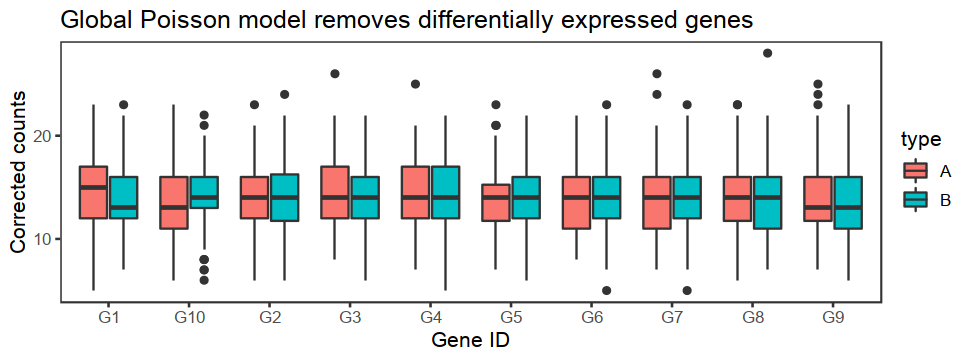

In [57]:
exprs_sct %>% 
    t %>% data.frame() %>% 
    cbind(meta_data) %>% 
    tidyr::gather(gene, val, -type, -nUMI, -nGene) %>%
    ggplot(aes(gene, val, fill = type)) + 
        geom_boxplot() + 
        theme_test(base_size = 12) + 
        labs(x = 'Gene ID', y = 'Corrected counts',
             title = 'Global Poisson model removes differentially expressed genes')

## local Poisson regression

    Now let's allow each cell type to have its own mean nUMI

# AMP data 

    Let's test this hypothesis, that most genes are not differentially expressed between cell types
    


In [11]:
amp_bulk <- readRDS('/data/srlab/public/srcollab/AMP/amp_phase1_ra/data/filtered_log2tpm_lowinput_phase_1.rds')
meta_bulk <- readRDS('/data/srlab/public/srcollab/AMP/amp_phase1_ra/data/filtered_meta_lowinput_phase_1.rds')
# meta_bulk %>% head %>% t
# meta_bulk <- meta_bulk[, c('Sample.ID', 'Cell.type', 'Donor.ID')]


In [12]:
table(meta_bulk$Cell.type)


Fibroblast   Monocyte     T cell     B cell 
        45         47         47         28 

## Low input RNAseq samples differ in library complexity

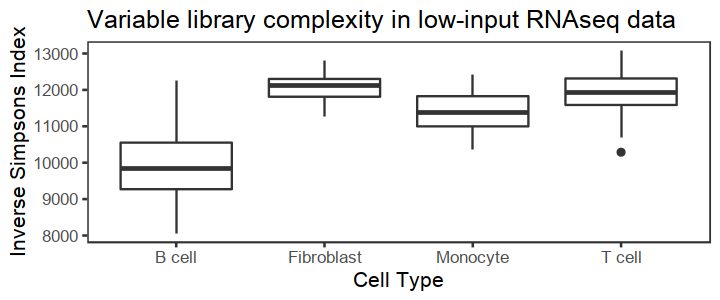

In [36]:
genes_use <- which(apply(amp_bulk > 0, 1, any))

fig.size(2.5, 6)
meta_bulk %>% 
#     cbind(isi = 1 / colSums(prop.table(prop.table(as.matrix(amp_bulk[genes_use, ]), 1), 2) ^ 2)) %>% 
    cbind(isi = 1 / colSums(prop.table(as.matrix(amp_bulk[genes_use, ]), 2) ^ 2)) %>% 
    ggplot(aes(Cell.type, isi)) + 
        geom_boxplot() + 
        labs(title = 'Variable library complexity in low-input RNAseq data',
             y = 'Inverse Simpsons Index', 
             x = 'Cell Type') + 
        theme_test(base_size = 12)


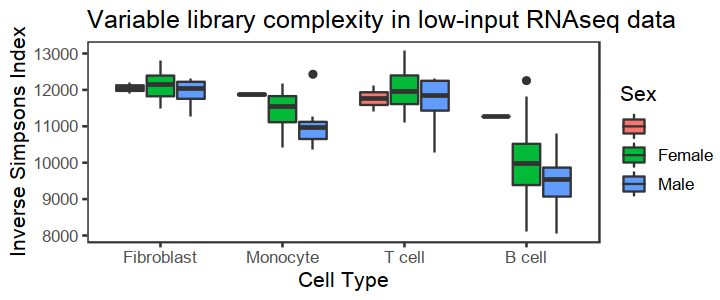

In [14]:
genes_use <- which(apply(amp_bulk > 0, 1, any))

fig.size(2.5, 6)
meta_bulk %>% 
#     cbind(isi = 1 / colSums(prop.table(prop.table(as.matrix(amp_bulk[genes_use, ]), 1), 2) ^ 2)) %>% 
    cbind(isi = 1 / colSums(prop.table(as.matrix(amp_bulk[genes_use, ]), 2) ^ 2)) %>% 
    ggplot(aes(Cell.type, isi, fill = Sex)) + 
        geom_boxplot() + 
        labs(title = 'Variable library complexity in low-input RNAseq data',
             y = 'Inverse Simpsons Index', 
             x = 'Cell Type') + 
        theme_test(base_size = 12)


## 85% of genes are differentially expressed between Fibroblasts and B cells

    accounting for library complexity, fewer appear differentialy expressed - but that would happen if the number of ON and OFF genes are biologically meaningful!

In [46]:
library(limma)
idx <- which(meta_bulk$Cell.type %in% c('Fibroblast', 'B cell'))
meta_bulk$dummy <- sample(2, nrow(meta_bulk), TRUE)
meta_bulk$Cell.type <- as.character(meta_bulk$Cell.type)

meta_use <- meta_bulk %>% 
    cbind(isi = 1 / colSums(prop.table(as.matrix(amp_bulk), 2) ^ 2))

# design <- model.matrix(~1 + Cell.type + Donor.ID + Disease.Tissue + Sex, meta_use[idx, ])

design <- model.matrix(~1 + Cell.type + Disease.Tissue + Sex + isi, meta_use[idx, ])
genes_use <- which(rowSums(amp_bulk[, meta_use[idx, 'Sample.ID']] > 1) >= 10)

dge <- amp_bulk[genes_use, meta_use$Sample.ID[idx]] %>%
    limma::lmFit(design) %>% 
    limma::eBayes() %>% 
    limma::topTable(coef = 2, number = 1e6)

dge %>% 
    subset(!is.na(P.Value)) %>% 
    with(table(adj.P.Val < .05 & abs(logFC) > log2(1.5))) %>% 
    prop.table()


    FALSE      TRUE 
0.4182304 0.5817696 

This raises again the issue that RNAseq is compositional. So even in low input RNAseq, we may be biased by the 

https://authors.library.caltech.edu/93419/1/564955.full.pdf

This paper argues that you need to use negative controls to interpret RNAseq data? 

In [31]:
dge[c('B2M', 'GAPDH', 'ACTB'), ]

,logFC,AveExpr,t,P.Value,adj.P.Val,B
B2M,-0.49369979,13.396986,-1.47720161,1.496552e-01,2.003569e-01,-6.354486
GAPDH,1.86651307,9.598235,7.80024438,8.094917e-09,4.849463e-08,9.866578
ACTB,0.00943467,11.121676,0.04992502,9.605007e-01,9.692493e-01,-7.437789
